<a href="https://colab.research.google.com/github/Bambillo1/NLP/blob/main/French2English_bidirectional_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf

In [2]:
from keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint
from wordcloud import WordCloud
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger, LearningRateScheduler,ReduceLROnPlateau
#from tensorflow.keras.metrics import binary_crossentropy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC


In [3]:
# Loading document txt function
def load_doc(url):
  df = pd.read_csv(url, delimiter="\t", header=None)
  return df

In [4]:
# Loading document txt
doc = load_doc("./fra.txt")
doc=doc.iloc[:,:2]
doc.columns=['english','french']
doc.head()

,english,french
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


The dataset being used is available on https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench.

In [5]:
#df  =pd.read_csv('/content/eng_-french.csv')
#df.head()

Separating the English and French data.

In [6]:
eng = doc['english']
fr = doc['french']

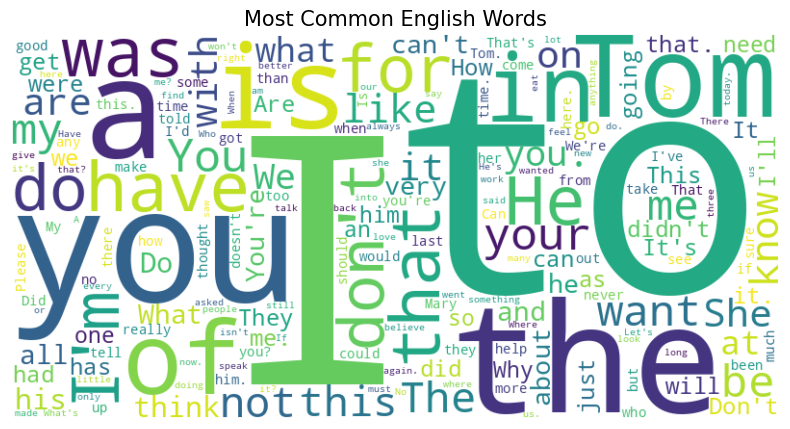

In [7]:
# Create a counter for English words
english_words_counter = Counter([word for sentence in eng for word in sentence.split()])
# Create a counter for French words
french_words_counter = Counter([word for sentence in fr for word in sentence.split()])

# Function to generate and display a word cloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Plot word clouds for English and French
plot_wordcloud(english_words_counter, 'Most Common English Words')



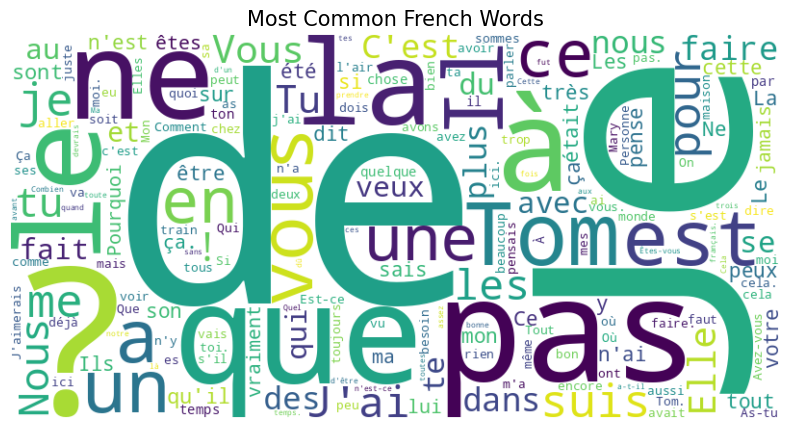

In [8]:
plot_wordcloud(french_words_counter, 'Most Common French Words')

<ipython-input-9-b2e49f31f825>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


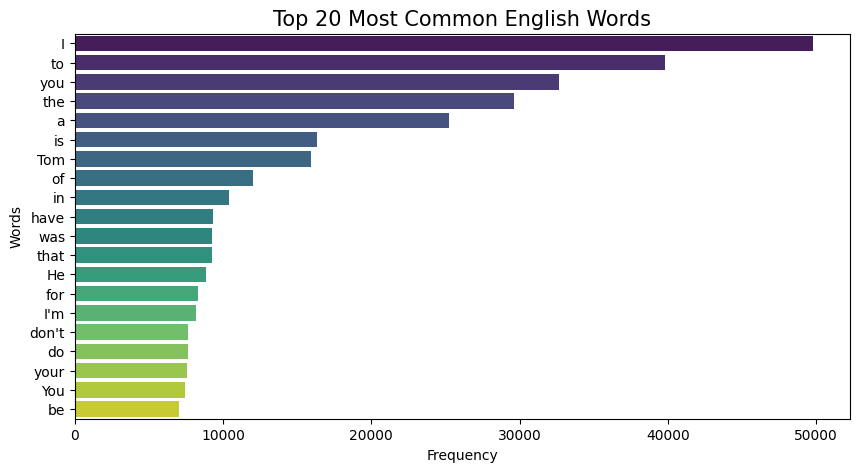

In [9]:
# Function to plot the most common words as a bar plot
def plot_most_common_words(counter, title, num_words=20):
    common_words = counter.most_common(num_words)
    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(title, fontsize=15)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plot bar charts for most common English and French words
plot_most_common_words(english_words_counter, 'Top 20 Most Common English Words')


<ipython-input-9-b2e49f31f825>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


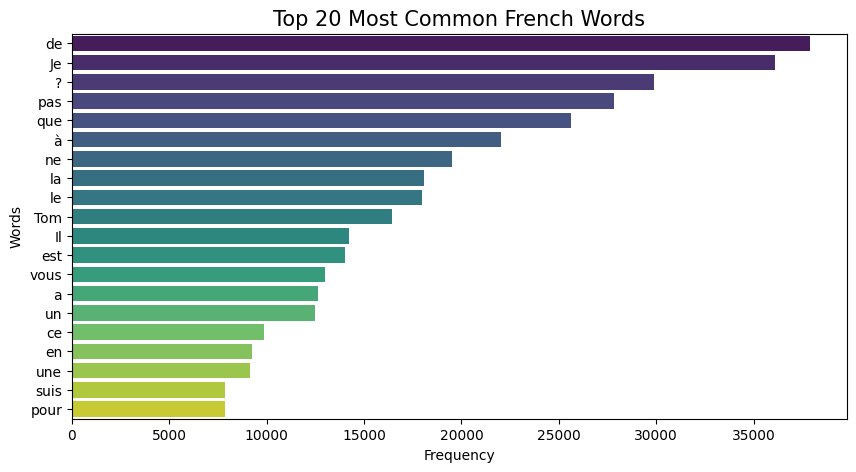

In [10]:
plot_most_common_words(french_words_counter, 'Top 20 Most Common French Words')

Some interesting stats about the datasets.

In [11]:
english_words_counter = Counter([word for sentence in eng for word in sentence.split()])
french_words_counter = Counter([word for sentence in fr for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in eng for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in fr for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1129385 English words.
28420 unique English words.
10 Most common words in the English dataset:
"I" "to" "you" "the" "a" "is" "Tom" "of" "in" "have"

1231329 French words.
46502 unique French words.
10 Most common words in the French dataset:
"de" "Je" "?" "pas" "que" "à" "ne" "la" "le" "Tom"


We will now create the function for Tokenization which involves cutting the raw text into manageable pieces. Tokenization divides the original text into tokens, which are words and sentences. These tokens aid in context comprehension or model development for NLP. By examining the word order in the text, tokenization aids in comprehending the text's meaning.

In [12]:
def tokenize(x):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer


We also have to pad each text as all the neural networks needs to have the inputs that should be in similar shape and size.

In [13]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = 55, padding = 'post')


The preprocess function will perform both of these tokenizing and padding tasks by incorporating the 2 previously defined functions.

In [14]:
def preprocess(x, y):

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [15]:
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(eng, fr)

In [16]:
import os
import pickle

# Create the directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the english_tokenizer as a pickle file
with open("model/english_tokenizer.pkl", 'wb') as handle:
    pickle.dump(english_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [17]:
import os
import pickle

# Create the directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the english_tokenizer as a pickle file
with open("model/french_tokenizer.pkl", 'wb') as handle:
    pickle.dump(french_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [18]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Max English sentence length: 55
Max French sentence length: 55
English vocabulary size: 15045
French vocabulary size: 31584


We also need a function to convert the final prediction by our model into text form.

In [19]:
def logits_to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

We will now create our Bidirectional RNN model with Embeddings.

In [20]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size ):


    learning_rate = 0.001

    # Build the layers
    model = Sequential()
    model.add(Embedding(french_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(english_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics= ['accuracy'])

    # Print the model
    return model


In [21]:
preproc_english_sentences.shape

(185583, 55)

In [22]:
# Reshape the input
tmp_x = pad(preproc_french_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))


# Ensure the target labels are 3D for the loss function
#preproc_french_sentences = preproc_french_sentences.reshape(*preproc_french_sentences.shape, 1)


# Train
model = bd_model(
    tmp_x.shape,
    preproc_english_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

model.summary()

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose = 1)
model_checkpoint = ModelCheckpoint(filepath='model/best_model.keras', save_best_only=True, monitor='val_loss', verbose =1)


history = model.fit(tmp_x, preproc_english_sentences, batch_size=64, epochs=5, validation_split=0.2,callbacks=[early_stopping, model_checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 256)           8085760   
                                                                 
 bidirectional (Bidirection  (None, 55, 512)           1050624   
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 55, 1024)          525312    
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 55, 1024)          0         
                                                                 
 time_distributed_1 (TimeDi  (None, 55, 15046)         15422150  
 stributed)                                                      
                                                        

In [23]:
# Evaluate the model using the evaluate function
loss, accuracy = model.evaluate(tmp_x, preproc_english_sentences)
print("Loss:", loss)
print("Accuracy:", accuracy)

5800/5800 [==============================] - 235s 41ms/step - loss: 0.2957 - accuracy: 0.9466
Loss: 0.2956547737121582
Accuracy: 0.9466288089752197


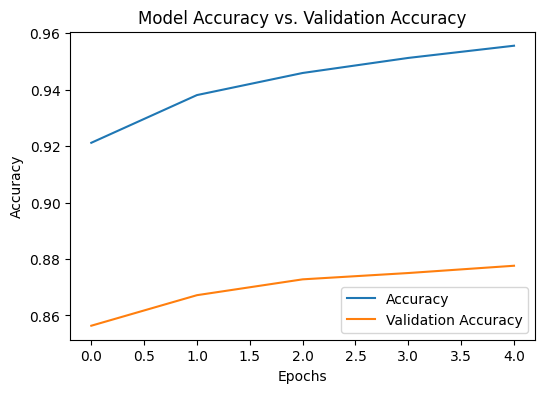

In [24]:
# Plot the loss and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

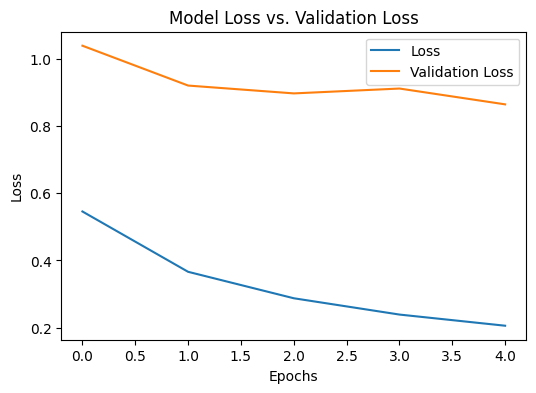

In [25]:
# Plot the loss and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's see how this translator works using an example.

In [26]:
i=10080

# Testing the model
print("Prediction:")
print(logits_to_text(model.predict(tmp_x[[i]])[0], english_tokenizer))

print("\nCorrect Translation:")
print(eng[i])

print("\nOriginal text:")
print(fr[i])

Prediction:
1/1 [==============================] - 1s 943ms/step
i want a little <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
I want a puppy.

Original text:
Je veux un petit chien.


In [28]:
import numpy as np


def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Testing the model
i = 1000
print("Prediction:")
print(logits_to_text(model.predict(tmp_x[[i]])[0], english_tokenizer))

print("\nCorrect Translation:")
print(eng[i])

print("\nOriginal text:")
print(fr[i])



Prediction:
1/1 [==============================] - 0s 20ms/step
i need me <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
I need it.

Original text:
Il me le faut.


Building model with GRU (Gated Recurrent Unit)

In [30]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size ):


    learning_rate = 0.001

    # Build the layers
    model_2 = Sequential()
    model_2.add(Embedding(french_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model_2.add(Bidirectional(GRU(256, return_sequences=True)))
    model_2.add(TimeDistributed(Dense(1024, activation='relu')))
    model_2.add(Dropout(0.5))
    model_2.add(TimeDistributed(Dense(english_vocab_size, activation='softmax')))

    # Compile model
    model_2.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics= ['accuracy'])

    # Print the model
    return model_2


In [ ]:
# Reshape the input
tmp_x = pad(preproc_french_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))


# Ensure the target labels are 3D for the loss function
#preproc_french_sentences = preproc_french_sentences.reshape(*preproc_french_sentences.shape, 1)


# Train
model_2 = bd_model(
    tmp_x.shape,
    preproc_english_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

model_2.summary()

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose = 1)
model_checkpoint = ModelCheckpoint(filepath='model/best_model_2.keras', save_best_only=True, monitor='val_loss', verbose =1)


history = model_2.fit(tmp_x, preproc_english_sentences, batch_size=64, epochs=5, validation_split=0.2,callbacks=[early_stopping, model_checkpoint])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 55, 256)           8085760   
                                                                 
 bidirectional_1 (Bidirecti  (None, 55, 512)           789504    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 55, 1024)          525312    
 stributed)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 55, 1024)          0         
                                                                 
 time_distributed_3 (TimeDi  (None, 55, 15046)         15422150  
 stributed)                                                      
                                                      

In [32]:
# Evaluate the model using the evaluate function
loss, accuracy = model_2.evaluate(tmp_x, preproc_english_sentences)
print("Loss:", loss)
print("Accuracy:", accuracy)

5800/5800 [==============================] - 238s 41ms/step - loss: 0.2713 - accuracy: 0.9516
Loss: 0.2713109850883484
Accuracy: 0.9516245126724243


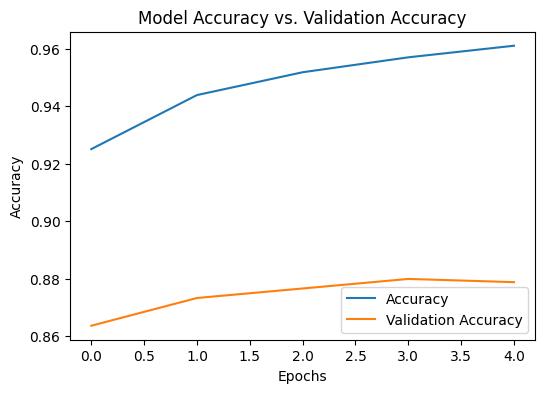

In [33]:
# Plot the loss and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

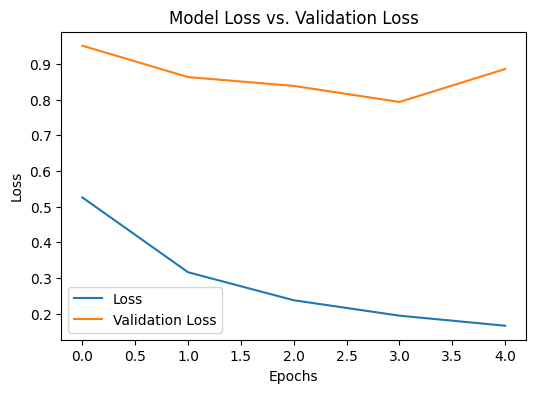

In [34]:
# Plot the loss and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
i=10080

# Testing the model
print("Prediction:")
print(logits_to_text(model.predict(tmp_x[[i]])[0], english_tokenizer))

print("\nCorrect Translation:")
print(eng[i])

print("\nOriginal text:")
print(fr[i])

Prediction:
1/1 [==============================] - 0s 18ms/step
i want a little <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
I want a puppy.

Original text:
Je veux un petit chien.


In [36]:
import numpy as np


def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Testing the model
i = 1000
print("Prediction:")
print(logits_to_text(model.predict(tmp_x[[i]])[0], english_tokenizer))

print("\nCorrect Translation:")
print(eng[i])

print("\nOriginal text:")
print(fr[i])



Prediction:
1/1 [==============================] - 0s 19ms/step
i need me <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
I need it.

Original text:
Il me le faut.
